# Notebook to generate plots using Sentinel-2 and ICESat-2 sea ice data

In [5]:
### Import necessary Python modules

import cartopy.crs as ccrs
#import cv2
#import gdal
import h5py
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
from pyproj import Proj, transform
#import osr
from scipy import ndimage, misc
import sys
from glob import glob
import rioxarray

## 1. Data ingestion and preparation

In [2]:
### Input data file names
# Pretty sure it's l=strong for these two examples
# When in forward orientation the rs are srong
# When in backward orientation the ls are strong
# between end of dec 2018 and july 2019 the spaceraft was in backward direction
example='Antarctic'
relStr='rel002'
figpath='./Figures/'+relStr+'/'
bufferRatio=150 #bigger number smaler width (try 100 for zoom in)
if example=='Arctic':
    print('Arctic example')
    beam_name='gt1l'
    date='20190526_NH'
    # Sentinel-2 surface reflectance single-band geoTIFF file
    imageFile = '/Users/aapetty/DATA/ICESat2/RT_T14XMQ_20190525T230121_B04.tif'
    # ATLAS DATA
    ATL07_dataFile = glob('/Users/aapetty/DATA/ICESat2/'+relStr+'/ATL07/ATL07-01_20190526*_08820301_002_01.h5')[0]
    ATL10_dataFile = glob('/Users/aapetty/DATA/ICESat2/'+relStr+'/ATL10/ATL10-01_20190526*_08820301_002_01.h5')[0]
    Slim = 80.73
    Nlim = 80.93
    #Slim = 80.73 
    #Nlim = 80.78
else:
    print('Antarctic example')
    beam_name='gt2l'
    date='20190317_SH'
    # Sentinel-2 surface reflectance single-band geoTIFF file
    imageFile = '/Users/aapetty/DATA/ICESat2/RT_T20CPE_20190317T122209_B04.tif'
    # ATLAS DATA
    ATL07_dataFile = glob('/Users/aapetty/DATA/ICESat2/'+relStr+'/ATL07/ATL07-02_20190317*_12070201_002_01.h5')[0]
    ATL10_dataFile = glob('/Users/aapetty/DATA/ICESat2/'+relStr+'/ATL10/ATL10-02_20190317*12070201_002_01.h5')[0]
    Slim = -73 
    Nlim = -72.6
    
#if (relStr=='rel002'):
#    atl10_ssh_lead_val=1
#elif (relStr=='rel003'):
#    atl10_ssh_lead_val=2

Antarctic example


In [3]:
### Check if geoTIFF file is valid

try:
    geoTIFF = gdal.Open(imageFile)
except IOError:
    sys.exit('geoTIFF file is not a valid file')

In [4]:
### Check if ICESat-2 ATLAS file is valid
#print(IS2_dataFile)
try:
    ATL07file = h5py.File(ATL07_dataFile, 'r')
except IOError:
    sys.exit('not a valid file')

In [5]:
### Check if ICESat-2 ATLAS file is valid
#print(IS2_dataFile)
try:
    ATL10file = h5py.File(ATL10_dataFile, 'r')
except IOError:
    sys.exit('not a valid file')

In [6]:
ATL10file

<HDF5 file "ATL10-02_20190317111321_12070201_002_01.h5" (mode r)>

In [7]:
### Read geoTIFF file and print information

# Image size
geoTIFF_size_x = geoTIFF.RasterXSize # Size of x
geoTIFF_size_y = geoTIFF.RasterYSize # Size of y

# Geographic information (geocoded extent, projection, etc.)
geoTIFF_geo_trans = geoTIFF.GetGeoTransform()   # UL corner x-coordinate, W-E pixel size, rotation (0 if N up),
                                                # UL corner y-coordinate, rotation (0 if N up), N-S pixel size
    
geoTIFF_proj = geoTIFF.GetProjection() # Geographic projection information
geoTIFF_inproj = osr.SpatialReference()
geoTIFF_inproj.ImportFromWkt(geoTIFF_proj)

# Convert WKT projection information to a CartoPy projection
geoTIFF_projcp = geoTIFF_inproj.GetAuthorityCode('PROJCS')
#geoTIFF_projection = ccrs.epsg(geoTIFF_projcp)

# Extract edge coordinates using half resolution cell to get coordinates of pixel center
geoTIFF_x_min = geoTIFF_geo_trans[0] + geoTIFF_geo_trans[1]*0.5
geoTIFF_x_max = geoTIFF_geo_trans[0] + geoTIFF_size_x*geoTIFF_geo_trans[1] - geoTIFF_geo_trans[1]*0.5
geoTIFF_y_min = geoTIFF_geo_trans[3] + geoTIFF_size_y*geoTIFF_geo_trans[5] + geoTIFF_geo_trans[5]*0.5
geoTIFF_y_max = geoTIFF_geo_trans[3] - geoTIFF_geo_trans[5]*0.5

geoTIFF_extent = [geoTIFF_x_min, geoTIFF_x_max, geoTIFF_y_min, geoTIFF_y_max]

# Convert geoTIFF image to data array
surfReflectance = geoTIFF.ReadAsArray()

# Close dataset
geoTIFF = None

# Print basic information
print('Image size: ', geoTIFF_size_x, geoTIFF_size_x)
print('Image projection EPGS code: ', geoTIFF_projcp)
print('Xmin: ', geoTIFF_extent[0])
print('Xmax: ', geoTIFF_extent[1])
print('Ymin: ', geoTIFF_extent[2])
print('Ymax: ', geoTIFF_extent[3])


Image size:  10980 10980
Image projection EPGS code:  32720
Xmin:  600005.0
Xmax:  709795.0
Ymin:  1890215.0
Ymax:  2000025.0


In [8]:
#geoTIFF_projection = ccrs.epsg(geoTIFF_projcp)
#import mpl_toolkits.basemap.pyproj as pyproj
#mib=pyproj.Proj("+init=EPSG:32614")

In [9]:
#import pyproj
#projT=pyproj.Proj("+init=EPSG:32614")
#projection = ccrs.from_proj(projT)

In [10]:
sc_orient = ATL07file['orbit_info/sc_orient'][0]
if (sc_orient==0):
    #backward
    if (beam_name[-1]=='l'):
        beamStrength='strong'
    else:
        beamStrength='weak'
elif (sc_orient==1):
    #forward
    if (beam_name[-1]=='l'):
        beamStrength='weak'
    else:
        beamStrength='strong'
else:
    print('no clear spaceraft orientation')

In [11]:
beamStrength

'strong'

In [12]:
## Read ATL07 parameters of interest
sc_orient = ATL07file['orbit_info/sc_orient'][:]
seg_delta_time = ATL07file[beam_name + '/sea_ice_segments/delta_time'][:]
seg_id = ATL07file[beam_name + '/sea_ice_segments/height_segment_id'][:] 
seg_lat = ATL07file[beam_name + '/sea_ice_segments/latitude'][:]
seg_lon = ATL07file[beam_name + '/sea_ice_segments/longitude'][:]
seg_track_dist = ATL07file[beam_name + '/sea_ice_segments/seg_dist_x'][:]
seg_conf = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_confidence'][:]
seg_height = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_height'][:]
seg_length = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_length_seg'][:]
seg_quality_binary = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_quality'][:]
seg_quality_flag = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_fit_quality_flag'][:]
seg_rms = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_rms'][:]
seg_ssh_flag = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_ssh_flag'][:]
seg_surf_err = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_surface_error_est'][:]
seg_type = ATL07file[beam_name + '/sea_ice_segments/heights/height_segment_type'][:]
seg_gaussian = ATL07file[beam_name +'/sea_ice_segments/heights/height_segment_w_gaussian'][:]
seg_backgr_rate = ATL07file[beam_name + '/sea_ice_segments/stats/backgr_r_200'][:]
seg_exmax_u1 = ATL07file[beam_name + '/sea_ice_segments/stats/exmax_mean_1'][:]
seg_exmax_u2 = ATL07file[beam_name + '/sea_ice_segments/stats/exmax_mean_2'][:]
seg_exmax_mix = ATL07file[beam_name + '/sea_ice_segments/stats/exmax_mix'][:]
seg_exmax_s1 = ATL07file[beam_name + '/sea_ice_segments/stats/exmax_stdev_1'][:]
seg_exmax_s2 = ATL07file[beam_name + '/sea_ice_segments/stats/exmax_stdev_2'][:]
seg_photon_rate = ATL07file[beam_name + '/sea_ice_segments/stats/photon_rate'][:]
seg_h_coarse_mn = ATL07file[beam_name + '/sea_ice_segments/stats/height_coarse_mn'][:]
seg_h_coarse_std = ATL07file[beam_name + '/sea_ice_segments/stats/height_coarse_stdev'][:]
seg_solar_elev = ATL07file[beam_name + '/sea_ice_segments/geolocation/solar_elevation'][:]

# Close HDF5 file
ATL07file = None

# Create Pandas data frame with all variables
ATL07dF = pd.DataFrame({'DeltaTime':seg_delta_time,
                      'SegmentID':seg_id,
                      'Latitude':seg_lat,
                      'Longitude':seg_lon,
                      'ATrackDist':seg_track_dist,
                      'HConfid':seg_conf,
                      'Height':seg_height,
                      'Length':seg_length,
                      'QualityBinary':seg_quality_binary,
                      'QualityFlag':seg_quality_flag,
                      'RMS':seg_rms,
                      'SSHFlag':seg_ssh_flag,
                      'HError':seg_surf_err,
                      'SegType':seg_type,
                      'WGaussian':seg_gaussian,
                      'BackgrRate':seg_backgr_rate,
                      'ExMean1':seg_exmax_u1,
                      'ExMean2':seg_exmax_u2,
                      'ExMix':seg_exmax_mix,
                      'ExStd1':seg_exmax_s1,
                      'ExStd2':seg_exmax_s2,
                      'PhRate':seg_photon_rate,
                      'HCoarseMn':seg_h_coarse_mn,
                      'HCoarseStd':seg_h_coarse_std,
                      'SolarElev':seg_solar_elev
                     })

    
# Transform WGS84 Latitude and Longitude to UTM X and Y
ATL_inProj = Proj(init='epsg:4326') # ATLAS data projection
out_proj = 'epsg:' + str(geoTIFF_projcp) # String with geoTIFF projection epsg code
ATL_outProj = Proj(init=out_proj) # GeotTIFF projection

seg_x_utm, seg_y_utm = transform(ATL_inProj, ATL_outProj, seg_lon, seg_lat) # Transform coordinates

# Add new coorinates to dataframe
ATL07dF['UTM_X'] = seg_x_utm
ATL07dF['UTM_Y'] = seg_y_utm

# Replace no-data value 3.4028235e+38 with Numpy NaN in data frame
ATL07dF = ATL07dF.replace(np.max(ATL07dF.Height), np.nan)

# Crop ICESat-2 data frame to imagery extent
ATL07dF_crop = ATL07dF[(ATL07dF['UTM_X'] > geoTIFF_extent[0]) & (ATL07dF['UTM_X'] < geoTIFF_extent[1]) & 
                   (ATL07dF['UTM_Y'] > geoTIFF_extent[2]) & (ATL07dF['UTM_Y'] < geoTIFF_extent[3])]

# Reset data frame index value
ATL07dF_crop = ATL07dF_crop.reset_index(drop=True)

# Print dataframe size 
print('Full dataset n. of columns: ', ATL07dF.shape[1])
print('Full dataset n. of segments: ', ATL07dF.shape[0])
print('Cropped dataset n. of columns: ', ATL07dF_crop.shape[1])
print('Cropped dataset n. of segments: ', ATL07dF_crop.shape[0])

/Applications/anaconda/envs/is2dev/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Applications/anaconda/envs/is2dev/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Full dataset n. of columns:  27
Full dataset n. of segments:  40476
Cropped dataset n. of columns:  27
Cropped dataset n. of segments:  6562


In [13]:
ATL10file

<HDF5 file "ATL10-02_20190317111321_12070201_002_01.h5" (mode r)>

In [14]:
## Read ATL10 parameters of interest
freeboard=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]
ssh_flag=ATL10file[beam_name]['freeboard_beam_segment']['height_segments']['height_segment_ssh_flag'][:]
seg_type_flag=ATL10file[beam_name]['freeboard_beam_segment']['height_segments']['height_segment_type'][:]
seg_length=ATL10file[beam_name]['freeboard_beam_segment']['height_segments']['height_segment_length_seg'][:]
freeboard_confidence=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['beam_fb_confidence'][:]
#seg_height=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['height_segment_height'][:]
height_segment_id=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['height_segment_id'][:]
lons=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['longitude'][:]
lats=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['latitude'][:]
deltaTime=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['delta_time'][:]-ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['delta_time'][0]

#seg_length = ATL10file[beam_name + '/sea_ice_segments/heights/height_segment_length_seg'][:]
#seg_quality = ATL10file[beam_name + '/sea_ice_segments/heights/height_segment_quality'][:]
#seg_rms = ATL10file[beam_name + '/sea_ice_segments/heights/height_segment_rms'][:]

segDist=ATL10file[beam_name]['freeboard_beam_segment']['beam_freeboard']['seg_dist_x'][:] #-f1[beam]['freeboard_beam_segment']['beam_freeboard']['seg_dist_x'][0]


lead_loc=ATL10file[beam_name]['leads']['ssh_ndx'][:]
    
#lead_id = height_segment_id[lead_loc]
lead_flag = np.zeros((np.size(height_segment_id)))
# ADD SIZE
lead_flag[lead_loc]=1

#seg_backgr_rate = ATL10file[beam_name + '/sea_ice_segments/stats/backgr_r_200'][:]
#seg_exmax_u1 = ATL10file[beam_name + '/sea_ice_segments/stats/exmax_mean_1'][:]
#seg_exmax_u2 = ATL10file[beam_name + '/sea_ice_segments/stats/exmax_mean_2'][:]
#seg_exmax_mix = ATL10file[beam_name + '/sea_ice_segments/stats/exmax_mix'][:]
#seg_exmax_s1 = ATL10file[beam_name + '/sea_ice_segments/stats/exmax_stdev_1'][:]
#seg_exmax_s2 = ATL10file[beam_name + '/sea_ice_segments/stats/exmax_stdev_2'][:]
#seg_photon_rate = ATL10file[beam_name + '/sea_ice_segments/stats/photon_rate'][:]
#seg_h_coarse_mn = ATL10file[beam_name + '/sea_ice_segments/stats/height_coarse_mn'][:]
#seg_h_coarse_std = ATL10file[beam_name + '/sea_ice_segments/stats/height_coarse_stdev'][:]
#seg_solar_elev = ATL10file[beam_name + '/sea_ice_segments/geolocation/solar_elevation'][:]

# Close HDF5 file
#ATL10file = None

# Create Pandas data frame with all variables
ATL10dF = pd.DataFrame({'freeboard':freeboard, 'Longitude':lons, 'Latitude':lats, 'delta_time':deltaTime,
                      'ATrackDist':segDist, 'height_segment_id': height_segment_id, 'lead_flag':lead_flag, 
                        'ssh_flag':ssh_flag, 'seg_type_flag':seg_type_flag, 'seg_length': seg_length})


    
# Transform WGS84 Latitude and Longitude to UTM X and Y
#ATL_inProj = Proj(init='epsg:4326') # ATLAS data projection
#out_proj = 'epsg:' + str(geoTIFF_projcp) # String with geoTIFF projection epsg code
#ATL_outProj = Proj(init=out_proj) # GeotTIFF projection

seg_x_utm, seg_y_utm = transform(ATL_inProj, ATL_outProj, lons, lats) # Transform coordinates

# Add new coorinates to dataframe
ATL10dF['UTM_X'] = seg_x_utm
ATL10dF['UTM_Y'] = seg_y_utm

# Replace no-data value 3.4028235e+38 with Numpy NaN in data frame
#ATL10dF = ATL10dF.replace(np.max(ATL10dF.freeboard), np.nan)
# dF = dF[(dF['freeboard']<maxFreeboard)]
# Crop ICESat-2 data frame to imagery extent
ATL10dF_crop = ATL10dF[(ATL10dF['UTM_X'] > geoTIFF_extent[0]) & (ATL10dF['UTM_X'] < geoTIFF_extent[1]) & 
                   (ATL10dF['UTM_Y'] > geoTIFF_extent[2]) & (ATL10dF['UTM_Y'] < geoTIFF_extent[3])]

# Reset data frame index value
ATL10dF_crop = ATL10dF_crop.reset_index(drop=True)

# Print dataframe size 
print('Full dataset n. of columns: ', ATL10dF.shape[1])
print('Full dataset n. of segments: ', ATL10dF.shape[0])
print('Cropped dataset n. of columns: ', ATL10dF_crop.shape[1])
print('Cropped dataset n. of segments: ', ATL10dF_crop.shape[0])

Full dataset n. of columns:  12
Full dataset n. of segments:  38396
Cropped dataset n. of columns:  12
Cropped dataset n. of segments:  6147


In [15]:
#lead_flag

In [16]:
### Extract Sentinel-2 surface reflectance values at ICESat-2 segment locations

# Function to extract imagery pixel values at locations of ICESat-2 data
def get_value_at_point(array_from, pos):
    """ Extract raster value at given position from coordinates """
    samp_x = int((pos[0] - geoTIFF_geo_trans[0]) / geoTIFF_geo_trans[1])
    samp_y = int((pos[1] - geoTIFF_geo_trans[3]) / geoTIFF_geo_trans[5])

    return array_from[samp_y-1, samp_x-1]

# Preallocate empty array
dF_length = ATL07dF_crop.shape[0]
band_value = np.empty([dF_length, 1])

# Extract imagery pixel values at locations of ICESat-2 data
for i in range(0, dF_length):
    band_value[i] = get_value_at_point(surfReflectance, (ATL07dF_crop['UTM_X'][i], ATL07dF_crop['UTM_Y'][i]))

# Add new column to data frame
ATL07dF_crop['BandValue'] = band_value

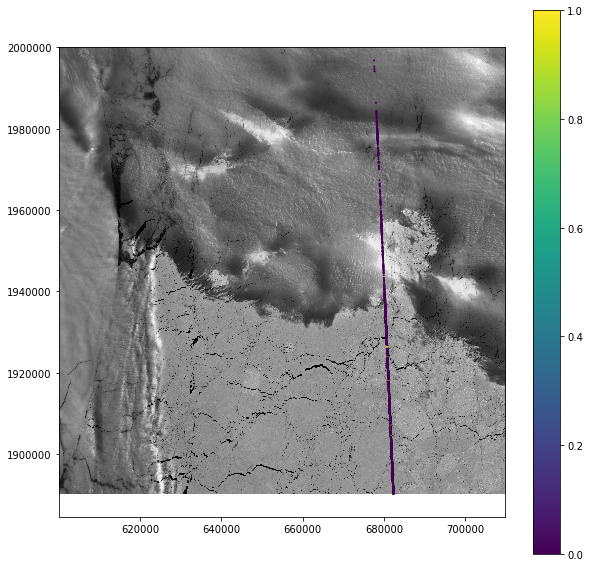

In [17]:
### Plot Sentinel-2 image with ICESat-2 beam overlaid

# Select ICESat-2 parameter to plot
# 'DeltaTime', 'SegmentID', 'Latitude', 'Longitude', 'ATrackDist', HConfid', 'Height', 'Length', 
# 'Quality', 'RMS', 'SSHFlag', 'HError', 'SegType', 'WGaussian', 'BackgrRate', 'ExMean1', 'ExMean2', 'ExMix',
# 'ExStd1', 'ExStd2', 'PhRate', 'HCoarseMn', 'HCoarseStd', 'SolarElev','UTM_X', 'UTM_Y'

IS2_param = 'SSHFlag'

# Make plot
%matplotlib inline 

#subplot_kw = dict(projection=geoTIFF_projection)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot image as grayscale
im = ax.imshow(surfReflectance, extent=geoTIFF_extent, origin='upper', cmap='gray')

# Overlay ICESat-2 data
plt.scatter(ATL07dF_crop['UTM_X'], ATL07dF_crop['UTM_Y'], s=1, c=ATL07dF_crop[IS2_param], cmap='viridis')
plt.colorbar()

## 2. Area of Interest selection

In [18]:
### Set latitude limits of AOI



In [19]:
### Subset datasets to limits
sub_dF07 = ATL07dF_crop[(ATL07dF_crop['Latitude'] < Nlim) & (ATL07dF_crop['Latitude'] > Slim) ]

# Reset data frame index value
sub_dF07 = sub_dF07.reset_index(drop=True)

# Print dataframe size 
print('AOI n. of columns: ', sub_dF07.shape[1], " * added surface refelctance value.")
print('AOI n. of points: ', sub_dF07.shape[0])

AOI n. of columns:  28  * added surface refelctance value.
AOI n. of points:  5733


In [20]:
### Subset datasets to limits
sub_dF10 = ATL10dF_crop[(ATL10dF_crop['Latitude'] < Nlim) & (ATL10dF_crop['Latitude'] > Slim) ]

# Reset data frame index value
sub_dF10 = sub_dF10.reset_index(drop=True)

# Print dataframe size 
print('AOI n. of columns: ', sub_dF10.shape[1], " * added surface refelctance value.")
print('AOI n. of points: ', sub_dF10.shape[0])

AOI n. of columns:  12  * added surface refelctance value.
AOI n. of points:  5538


In [21]:
### Determine ICESat-2 ground track inclination in Sentinel-2 image

# Trigonometry calculations
a = ATL07dF_crop.UTM_Y.iloc[0] - ATL07dF_crop.UTM_Y.iloc[-1]
b = ATL07dF_crop.UTM_X.iloc[0] - ATL07dF_crop.UTM_X.iloc[-1]
c = np.sqrt((a**2) + (b**2))

cosA = (b**2 + c**2 - a**2) / (2*b*c)
inclin = np.arccos(cosA)
inclin_deg = np.degrees(inclin)

# Adjust size of buffer zone from ICESat-2 ground track depending on length of subset
buffer = c/bufferRatio

deltaX = buffer * np.sin(inclin)
deltaY = buffer * np.cos(inclin)

# Compute coordinates of corners of AOI

# Descending satellite pass
if ATL07dF_crop.UTM_Y.iloc[0] > ATL07dF_crop.UTM_Y.iloc[-1]:
    rev = True # set flag to determine how to apply rotation
    
    UL_x = sub_dF07.UTM_X.iloc[0] - deltaX
    UL_y = sub_dF07.UTM_Y.iloc[0] + deltaY

    UR_x = sub_dF07.UTM_X.iloc[0] + deltaX
    UR_y = sub_dF07.UTM_Y.iloc[0] - deltaY

    LL_x = sub_dF07.UTM_X.iloc[-1] - deltaX
    LL_y = sub_dF07.UTM_Y.iloc[-1] + deltaY

    LR_x = sub_dF07.UTM_X.iloc[-1] + deltaX
    LR_y = sub_dF07.UTM_Y.iloc[-1] - deltaY

# Ascending satellite pass    
if ATL07dF_crop.UTM_Y.iloc[0] < ATL07dF_crop.UTM_Y.iloc[-1]:
    rev = False # set flag to determine how to apply rotation
    
    UL_x = sub_dF07.UTM_X.iloc[0] - deltaX
    UL_y = sub_dF07.UTM_Y.iloc[0] - deltaY

    UR_x = sub_dF07.UTM_X.iloc[0] + deltaX
    UR_y = sub_dF07.UTM_Y.iloc[0] + deltaY

    LL_x = sub_dF07.UTM_X.iloc[-1] - deltaX
    LL_y = sub_dF07.UTM_Y.iloc[-1] - deltaY

    LR_x = sub_dF07.UTM_X.iloc[-1] + deltaX
    LR_y = sub_dF07.UTM_Y.iloc[-1] + deltaY

# Print AOI information
print('ICESat-2 inclination angle in imagery coordinate system: ', inclin_deg)
print('AOI coordinates:')
print('UL: ', UL_x, UL_y)
print('UR: ', UR_x, UR_y)
print('LR: ', LR_x, LR_y)
print('LL: ', LL_x, LL_y)

ICESat-2 inclination angle in imagery coordinate system:  87.43205901409985
AOI coordinates:
UL:  681559.8526990239 1890977.8284055493
UR:  682981.245909154 1891041.5765539636
LR:  680996.7030766563 1936045.087755893
LL:  679575.3098665263 1935981.3396074786


In [22]:
buffer

711.4110071242692

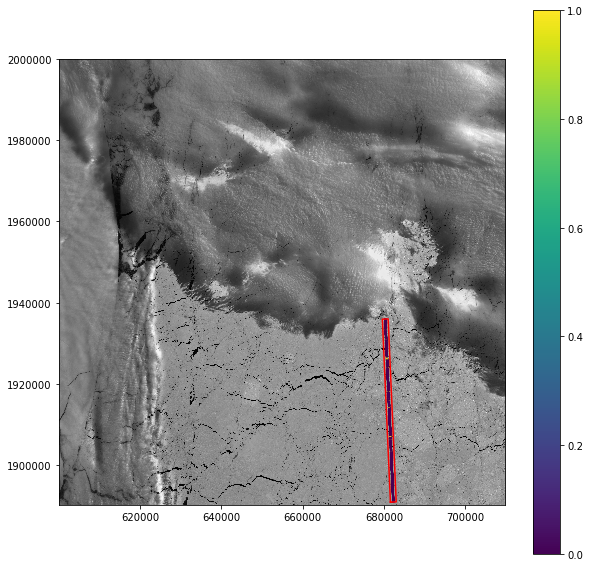

In [23]:
### Make new plot of Sentinel-2 image with ICESat-2 beam overlaid (AOI only)

# Make plot
%matplotlib inline 

#subplot_kw = dict(projection=geoTIFF_projection)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot image as grayscale
im = ax.imshow(surfReflectance, extent=geoTIFF_extent, origin='upper', cmap='gray')

# Overlay ICESat-2 data
plt.scatter(sub_dF07['UTM_X'], sub_dF07['UTM_Y'], s=1, c=sub_dF07[IS2_param], cmap='viridis')
plt.plot([UL_x, LL_x, LR_x, UR_x, UL_x], [UL_y, LL_y, LR_y, UR_y, UL_y], c='r')
plt.colorbar()


In [24]:
### Create shapefile with extent of AOI to be used for image cropping

# Define function
def createShapefile(filename, LL_x, LL_y, UL_x, UL_y, UR_x, UR_y, LR_x, LR_y):
    import ogr

    driver = ogr.GetDriverByName('ESRI Shapefile')

    datasource = driver.CreateDataSource(filename)
    layer = datasource.CreateLayer('layerName',geom_type=ogr.wkbPolygon)

    outline = ogr.Geometry(type=ogr.wkbLinearRing)
    outline.AddPoint(LL_x, LL_y)
    outline.AddPoint(UL_x, UL_y)
    outline.AddPoint(UR_x, UR_y)
    outline.AddPoint(LR_x, LR_y)
    outline.AddPoint(LL_x, LL_y)
    polygon = ogr.Geometry(type=ogr.wkbPolygon)
    polygon.AddGeometry(outline)

    #create feature object with polygon geometry type from layer object:
    feature = ogr.Feature( layer.GetLayerDefn() )
    feature.SetGeometry(polygon)
    layer.CreateFeature(feature)
   
    return

# Call function to create AOI polygon shapefile
createShapefile('AOIPolygon.shp', LL_x, LL_y, UL_x, UL_y, UR_x, UR_y, LR_x, LR_y)

### This part runs GDAL utilities from the command line. Must be adapted to local environment

In [25]:
### Run gdalwarp to crop Sentinel-2 image to AOI

# Provide full path to gdalwarp on local system
path_to_gdalwarp = '/Applications/anaconda/envs/is2dev/bin/gdalwarp'

# Remove pre-existing file if needed
! rm AOI.*

# Run gdalwarp
! $path_to_gdalwarp -cutline AOIPolygon.shp -crop_to_cutline -dstalpha $imageFile AOI.tif

#gdal.Warp()

Creating output file that is 340P x 4506L.
Processing /Users/aapetty/DATA/ICESat2/RT_T20CPE_20190317T122209_B04.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image /Users/aapetty/DATA/ICESat2/RT_T20CPE_20190317T122209_B04.tif.
Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
...10...20...30...40...50...60...70...80...90...100 - done.


### -----------------------------
### End of command line use

In [26]:
### Convert GEOTiff AOI file to JPG for subsequent use

# Options to convert GEOTiff image to JPEG
options_list = ['-ot Byte','-of JPEG','-b 1','-scale'] 
options_string = " ".join(options_list)

# Use gdal_translate in Python
gdal.Translate('AOI.jpg',
               'AOI.tif',
               options=options_string)

# Read new JPEG image
#image = cv2.imread('AOI.tif')
import matplotlib.pyplot as plt
image = plt.imread('AOI.jpg')

In [27]:
# Rotate image by inclination angle according to satellite pass
# Descending
if rev is True:
    rot_im = ndimage.rotate(image, 180-inclin_deg, reshape=True, order=1)
# Ascending
if rev is False:
    rot_im = ndimage.rotate(image, inclin_deg, reshape=True, order=1)

In [28]:
### Trim edges to remove image padding
padNum=12
crop = np.delete(rot_im,np.where(~rot_im.any(axis=0))[0], axis=1)
crop = np.delete(crop,np.where(~crop.any(axis=1))[0], axis=0)
crop = np.delete(crop, range(padNum), 0)
crop = np.delete(crop, range(crop.shape[0]-padNum,crop.shape[0]), 0)
crop = np.delete(crop, range(padNum), 1)
crop = np.delete(crop, range(crop.shape[1]-padNum,crop.shape[1]), 1)
#import numpy.ma as ma
#crop=ma.masked_where(crop<1, crop)

## 3. Generate final plot

In [29]:
### Prepare data for plotting

# Filp image if necessary
if rev is False:
    crop = np.flipud(np.fliplr(crop))

# Convert distances from meters to kilometers with respect to first segment in AOI
sub_dF07['ATrackDist'] = sub_dF07['ATrackDist'] - sub_dF07['ATrackDist'].iloc[0]
sub_dF07['ATrackDist'] = sub_dF07['ATrackDist'].multiply(0.001)

# Convert distances from meters to kilometers with respect to first segment in AOI
sub_dF10['ATrackDist'] = sub_dF10['ATrackDist'] - sub_dF10['ATrackDist'].iloc[0]
sub_dF10['ATrackDist'] = sub_dF10['ATrackDist'].multiply(0.001)

# Convert background rate to MHz
sub_dF07['BackgrRate'] = sub_dF07['BackgrRate'].multiply(0.000001)

In [30]:
atl07_segs=np.size(sub_dF07['SSHFlag'].values)
atl07_segs

5733

In [31]:
ssh07_segs=np.size(np.where(sub_dF07['SSHFlag'] > 0.5))
ssh07_segs

165

In [32]:
specular_segs=np.size(np.where((sub_dF07['SegType'] > 1.5)&(sub_dF07['SegType'] < 5.5)))
specular_segs

240

In [33]:
darklead_segs=np.size(np.where(sub_dF07['SegType'] > 5.5))
darklead_segs

0

In [34]:
atl10_segs=np.size(sub_dF10['ssh_flag'].values)
atl10_segs

5538

In [35]:
ssh10_segs=np.size(np.where(sub_dF10['ssh_flag'] > 0.5))
ssh10_segs

165

In [36]:
mean_fb=np.round(np.mean(sub_dF10['freeboard']), decimals=3)
mean_fb

0.314

In [37]:
#mean_fb2=np.round(np.mean(sub_dF10['freeboard'][sub_dF10['freeboard']>0.05]), decimals=3)
#mean_fb2

In [38]:
import numpy.ma as ma
mafreeboards=ma.masked_where(sub_dF10['freeboard']<0.06, sub_dF10['freeboard'])

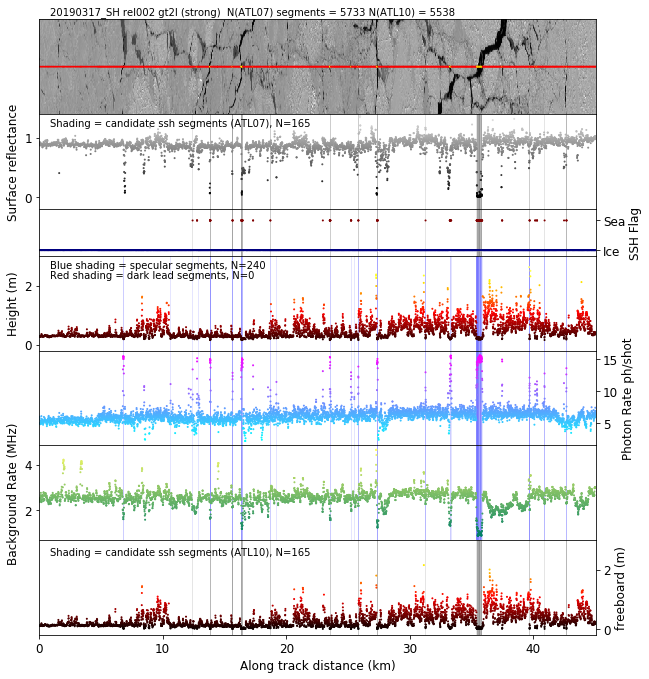

In [39]:
### Generate final plot
shadingSize=30

%matplotlib inline

# Create binary colormap for SSH Flag
cmap_ssh = colors.ListedColormap(['red', 'yellow'])

# Plot 1
fig= plt.figure(figsize=(9,9.5))
fig.patch.set_facecolor('xkcd:white')

ax1 = plt.subplot2grid((13, 1), (0, 0), rowspan=2)
plt.imshow(crop, extent=[sub_dF07.ATrackDist.iloc[0], sub_dF07.ATrackDist.iloc[-1], -buffer/1000, +buffer/1000], aspect='auto', cmap='gray', vmin=0, vmax=255)
plt.scatter(sub_dF07['ATrackDist'],np.zeros(len(sub_dF07['ATrackDist'])), c=sub_dF07['SSHFlag'], s=buffer/10000, cmap=cmap_ssh)
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
plt.autoscale(enable=True, axis='x', tight=True)
#plt.suptitle(date, color='k', fontsize=12)
ax1.annotate(date+' '+relStr+' '+beam_name+' ('+beamStrength+')  N(ATL07) segments = '+str(atl07_segs)+' N(ATL10) = '+str(atl10_segs),xy=(0.02, 1.05), xycoords='axes fraction')

# Plot 2
ax2 = plt.subplot2grid((13, 1), (2, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if (row['SSHFlag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)

plt.scatter(sub_dF07['ATrackDist'],sub_dF07['BandValue'], c=sub_dF07['BandValue'], s=1, cmap='gray', vmin = 0, vmax = 1.5, zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax2.xaxis.set_ticklabels([])
ax2.set_yticks([0, 1])
plt.ylim(-0.2,1.4)
plt.ylabel('Surface reflectance', color='k', fontsize=12)
ax2.tick_params(axis='y', colors='k', labelsize=12)
ax2.annotate('Shading = candidate ssh segments (ATL07), N='+str(ssh07_segs),xy=(0.02, 0.87), xycoords='axes fraction')
# Plot 3
ax3 = plt.subplot2grid((13, 1), (4, 0), rowspan=1)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    #if ((row['SSHFlag'] > 0.1) & (row['SSHFlag'] < 1.2)):
    if (row['SSHFlag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)

plt.scatter(sub_dF07['ATrackDist'],sub_dF07['SSHFlag'], c=sub_dF07['SSHFlag'], s=1, cmap='jet', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.tick_right()
plt.ylabel('SSH Flag', color='k', fontsize=12)
ax3.yaxis.set_label_position("right")
plt.yticks([0,1], ['Ice', 'Sea'], fontsize=12)
plt.ylim(-0.2,1.4)
ax3.tick_params(axis='y', colors='k')

# Plot 4
ax4 = plt.subplot2grid((13, 1), (5, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    # cloud
    if row['SegType'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.1)
    # Specular lead
    elif ((row['SegType'] > 1.5) & (row['SegType'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    # Dark lead
    elif row['SegType'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.1)
            
plt.scatter(sub_dF07['ATrackDist'],sub_dF07['Height'], c=sub_dF07['Height'], s=1, vmin=0, vmax=3, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax4.xaxis.set_ticklabels([])
plt.ylabel('Height (m)', color='k', fontsize=12)
ax4.tick_params(axis='y', colors='k', labelsize=12)
plt.ylim(-0.2,3)
ax4.annotate('Blue shading = specular segments, N='+str(specular_segs),xy=(0.02, 0.87), xycoords='axes fraction')
ax4.annotate('Red shading = dark lead segments, N='+str(darklead_segs),xy=(0.02, 0.76), xycoords='axes fraction')

# Plot 5
ax5 = plt.subplot2grid((13, 1), (7, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    #x0 = row['ATrackDist'] - row['Length']/2000
    #x1 = row['ATrackDist'] + row['Length']/2000
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    # cloud
    if row['SegType'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.1)
    # specular lead
    elif ((row['SegType'] > 1.5) & (row['SegType'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['SegType'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.1)
            
plt.scatter(sub_dF07['ATrackDist'],sub_dF07['PhRate'], c=sub_dF07['PhRate'], s=1, cmap='cool', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.tick_right()
plt.ylabel('Photon Rate ph/shot', color='k', fontsize=12)
ax5.yaxis.set_label_position("right")
ax5.tick_params(axis='y', colors='k', labelsize=12)

# Plot 6
ax6 = plt.subplot2grid((13, 1), (9, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    # cloud
    if row['SegType'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.1)
    # specular lead
    elif ((row['SegType'] > 1.5) & (row['SegType'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['SegType'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.1)
            
plt.scatter(sub_dF07['ATrackDist'],sub_dF07['BackgrRate'], c=sub_dF07['BackgrRate'], s=1, cmap='summer', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax6.xaxis.set_ticklabels([])
plt.ylabel('Background Rate (MHz)', color='k', fontsize=12)
plt.xlabel('Along track distance (km)', color='k', fontsize=16)
ax6.tick_params(axis='y', colors='k', labelsize=12)
ax6.tick_params(axis='x', colors='k', labelsize=12)

### Plot 7 (ICESat-2 background rate)
ax7 = plt.subplot2grid((13, 1), (11, 0), rowspan=2)

# Add lead_flag=1 shading
#for index, row in sub_dF10.iterrows():
    # CHANGE TO LEAD LENGTH
#    x0 = row['ATrackDist'] - shadingSize*2/2000
#    x1 = row['ATrackDist'] + shadingSize*2/2000
#    
#    if row['lead_flag'] > 0.1:
#        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)


for index, row in sub_dF10.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    #if ((row['ssh_flag'] > 1.1) & (row['ssh_flag'] < 2.2)):
    if (row['ssh_flag'] > 0.5):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)
        
plt.scatter(sub_dF10['ATrackDist'],sub_dF10['freeboard'], c=sub_dF10['freeboard'], vmin=0, vmax=3, s=1, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('freeboard (m)', color='k', fontsize=12)
ax7.yaxis.set_label_position("right")
ax7.yaxis.tick_right()
plt.xlabel('Along track distance (km)', color='k', fontsize=12)
ax7.tick_params(axis='y', colors='k', labelsize=12)
ax7.tick_params(axis='x', colors='k', labelsize=12)
ax7.annotate('Shading = candidate ssh segments (ATL10), N='+str(ssh10_segs),xy=(0.02, 0.84), xycoords='axes fraction')
#ax7.annotate('Mean = '+str(mean_fb)+' m / mean > 0.05 = '+str(mean_fb2)+' m',xy=(0.6, 0.84), xycoords='axes fraction')

plt.ylim(-0.2,3)

plt.subplots_adjust(left=0.06, right=0.92, top=0.96, bottom=0.06, wspace=0, hspace=0)
#plt.tight_layout()
### Save plot to file
plt.savefig(figpath+'FINAL_plot'+date+beam_name+relStr+str(Slim)+str(Nlim)+'.png', dpi=300)


In [40]:
### Save plot to file
#plt.savefig('FINAL_plot.png', edgecolor='none', bbox_inches='tight')

In [41]:
# Find the segments that are in ATL07 but not ATL10 
atlmask = np.isin(sub_dF07['SegmentID'].values, sub_dF10['height_segment_id'].values,  invert=True)
atlmaskint=atlmask.astype(int)
np.size(atlmask), np.size(np.nonzero(atlmaskint)[0])

(5733, 195)

In [42]:
#ssh ids in ATL10
ssh_ids=sub_dF07['SegmentID'].values[np.where(sub_dF07['SSHFlag'].values>0.5)]
ssh_inatl10 = np.isin(ssh_ids, sub_dF10['height_segment_id'].values)

In [43]:
#sub_dF07['SegmentID'].values[np.where(sub_dF07['SSHFlag'].values>0.5)]

In [44]:
#sub_dF10['height_segment_id'].values[np.where(sub_dF10['ssh_flag'].values>0.5)]

In [45]:
#ssh ids
radio_ids=sub_dF07['SegmentID'].values[np.where(sub_dF07['SegType'].values<1.5)]
radio_inatl10 = np.isin(radio_ids, sub_dF10['height_segment_id'].values,  invert=True)
radio_inatl10

array([False, False, False, ..., False, False, False])

In [46]:
sub_dF10_adj = sub_dF10[(sub_dF10['ssh_flag'] < 0.5) & (sub_dF10['seg_type_flag']==1 ) & (sub_dF10['freeboard']>0.04)]
#
mean_fb_adj=np.round(np.mean(sub_dF10_adj['freeboard']), decimals=3)


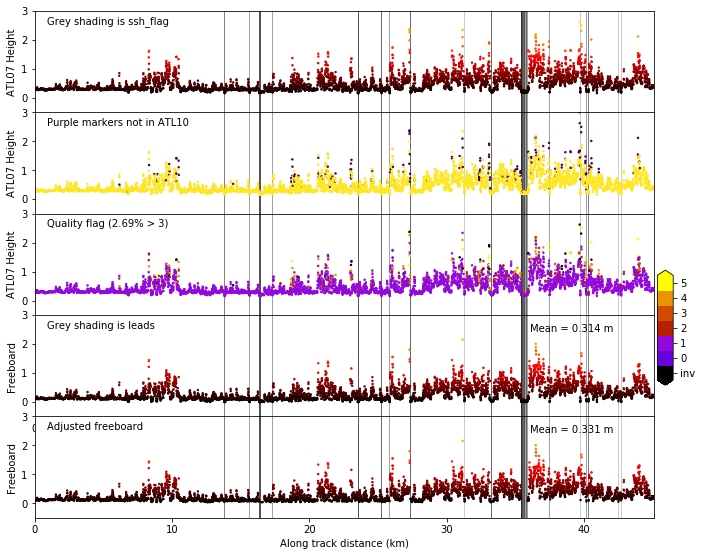

In [47]:
# Generate plot with white background
#%matplotlib qt
#%matplotlib inline
fig= plt.figure(figsize=(10,8))
#fig.patch.set_facecolor('xkcd:white')

#x0 = (sub_dF07['ATrackDist'] - sub_dF07['Length']/2000).values
#x1 = (sub_dF07['ATrackDist'] + sub_dF07['Length']/2000).values
#ssh = sub_dF07['SSHFlag'].values

# ATL07 heights ssh label
ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=1)


for index, row in sub_dF07.iterrows():
    #x0 = row['ATrackDist'] - row['Length']/2000
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if row['SSHFlag'] > 0.1:
        plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
        
plt.scatter(sub_dF07['ATrackDist'], sub_dF07['Height'], c=sub_dF07['Height'], cmap='hot', s=2, zorder=2)
plt.xlim(np.amin(sub_dF10['ATrackDist']), np.amax(sub_dF10['ATrackDist']))
ax1.xaxis.set_ticklabels([])
plt.ylim(-0.5, 3)
ax1.annotate('Grey shading is ssh_flag',xy=(0.02, 0.87), xycoords='axes fraction')
plt.ylabel('ATL07 Height')
# ATL07 heights (in atl10)
ax2 = plt.subplot2grid((5, 1), (1, 0), rowspan=1)
#for x in range(np.size(x0)):
    #print(x)
#for m in range(np.size(atlmask)):
#    if atlmask[m]==False:
#        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if row['SSHFlag'] > 0.1:
        plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
        
plt.scatter(sub_dF07['ATrackDist'], sub_dF07['Height'], c=atlmaskint, vmin=0, vmax=1, cmap='viridis_r', s=2, zorder=2)
plt.xlim(np.amin(sub_dF10['ATrackDist']), np.amax(sub_dF10['ATrackDist']))
plt.ylim(-0.5, 3)
ax2.xaxis.set_ticklabels([])
plt.ylabel('ATL07 Height')
ax2.annotate('Purple markers not in ATL10',xy=(0.02, 0.87), xycoords='axes fraction')

ax3 = plt.subplot2grid((5, 1), (2, 0), rowspan=1)
#for x in range(np.size(x0)):
    #print(x)
#for m in range(np.size(atlmask)):
#    if atlmask[m]==False:
#        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if row['SSHFlag'] > 0.1:
        plt.axvspan(x0,x1, facecolor='k', alpha=0.2)


cmap = plt.cm.get_cmap('gnuplot', 7)    # 11 discrete colors

imq=plt.scatter(sub_dF07['ATrackDist'], sub_dF07['Height'], c=sub_dF07['QualityFlag'], cmap=cmap, vmin=-1.5, vmax=5.5, s=2, zorder=2)
plt.xlim(np.amin(sub_dF10['ATrackDist']), np.amax(sub_dF10['ATrackDist']))
plt.ylim(-0.5, 3)
ax3.xaxis.set_ticklabels([])
plt.ylabel('ATL07 Height')
percent=np.round(np.size(np.where(sub_dF07['QualityFlag']>3))/np.size(sub_dF07['QualityFlag'])*100, decimals=2)

ax3.annotate('Quality flag ('+str(percent)+'% > 3)',xy=(0.02, 0.87), xycoords='axes fraction')

cax = fig.add_axes([0.925, 0.31, 0.022, 0.2])
cbar = plt.colorbar(imq,cax=cax, orientation='vertical', extend='both', use_gridspec=True)
#cbar.set_label('Quality flag', labelpad=28, rotation=0)
xticks1 = np.linspace(-1, 5, 7)
cbar.set_ticks(xticks1)
cbar.set_ticklabels(['inv', '0', '1', '2', '3', '4', '5'])
#plt.clim(-1.5,5.5)

ax4 = plt.subplot2grid((5, 1), (3, 0), rowspan=1)
#mask = np.isin(sub_DF['height_segment_id'].values, sub_DF10['height_segment_id'].values,  invert=True)
#for m in range(np.size(atlmask)):
#    if atlmask[m]==False:
#        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)
# Add lead_flag=1 shading
for index, row in sub_dF10.iterrows():
    # CHANGE TO LEAD LENGTH
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if row['ssh_flag'] > 0.1:
        plt.axvspan(x0,x1, facecolor='k', alpha=0.2)

ax4.annotate('Grey shading is leads',xy=(0.02, 0.87), xycoords='axes fraction')
plt.scatter(sub_dF10['ATrackDist'], sub_dF10['freeboard'], c=sub_dF10['freeboard'], cmap='hot', s=2, zorder=2)
#ax3.xaxis.set_ticklabels([])
plt.ylabel('Freeboard')
plt.xlabel('Along track distance (km)')
plt.xlim(np.amin(sub_dF10['ATrackDist']), np.amax(sub_dF10['ATrackDist']))
plt.ylim(-0.5, 3)
ax4.annotate('Mean = '+str(mean_fb)+' m',xy=(0.8, 0.84), xycoords='axes fraction')

ax5 = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
#mask = np.isin(sub_DF['height_segment_id'].values, sub_DF10['height_segment_id'].values,  invert=True)
#for m in range(np.size(atlmask)):
#    if atlmask[m]==False:
#        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)
# Add lead_flag=1 shading
for index, row in sub_dF10.iterrows():
    # CHANGE TO LEAD LENGTH
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if row['ssh_flag'] > 0.1:
        plt.axvspan(x0,x1, facecolor='k', alpha=0.2)

ax5.annotate('Adjusted freeboard',xy=(0.02, 0.87), xycoords='axes fraction')
plt.scatter(sub_dF10_adj['ATrackDist'], sub_dF10_adj['freeboard'], c=sub_dF10_adj['freeboard'], cmap='hot', s=2, zorder=2)
#ax3.xaxis.set_ticklabels([])
plt.ylabel('Freeboard')
plt.xlabel('Along track distance (km)')
plt.xlim(np.amin(sub_dF10['ATrackDist']), np.amax(sub_dF10['ATrackDist']))
plt.ylim(-0.5, 3)
ax5.annotate('Mean = '+str(mean_fb_adj)+' m',xy=(0.8, 0.84), xycoords='axes fraction')


plt.subplots_adjust(left=0.06, right=0.92, top=0.96, bottom=0.08, wspace=0, hspace=0)
#plt.tight_layout()
### Save plot to file
plt.savefig(figpath+'FINAL_plot'+date+beam_name+relStr+str(Slim)+str(Nlim)+'diagnostic.png', dpi=300)

In [48]:
percent=np.round(np.size(np.where(sub_dF07['QualityFlag']==4))/np.size(sub_dF07['QualityFlag'])*100, decimals=2)
percent

2.25

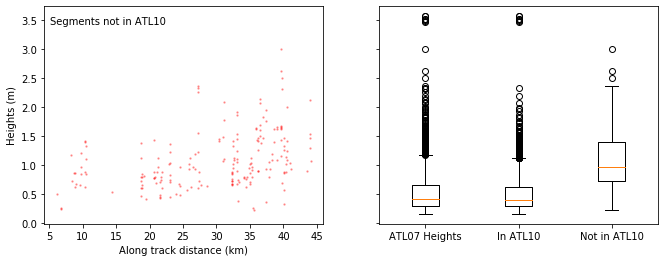

In [49]:
%matplotlib inline
#fig= plt.figure(figsize=(13,5))
#f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (11, 4), sharex=False, sharey=True)
plt.sca(ax1)
fig.patch.set_facecolor('xkcd:white')
plt.scatter(sub_dF07['ATrackDist'].values[atlmask], sub_dF07['Height'].values[atlmask], color='r', s=2, alpha=0.3)
#plt.scatter(sub_DF07['ATrackDist'].values[~atlmask], sub_DF07['elev'].values[~atlmask], color='b', s=2, alpha=0.3)
plt.annotate('Segments not in ATL10', xy=(0.02, 0.92), xycoords='axes fraction')
plt.xlabel('Along track distance (km)')
plt.ylabel('Heights (m)')
plt.sca(ax2)
plt.boxplot([sub_dF07['Height'].values[~np.isnan(sub_dF07['Height'].values)], sub_dF07['Height'].values[~atlmask][~np.isnan(sub_dF07['Height'].values[~atlmask])], sub_dF07['Height'].values[atlmask][~np.isnan(sub_dF07['Height'].values[atlmask])]])
ax2.set_xticklabels(['ATL07 Heights', 'In ATL10', 'Not in ATL10'])
plt.savefig(figpath+'FINAL_plot'+date+beam_name+relStr+str(Slim)+str(Nlim)+'diagnostic_boxplot.png', dpi=300)

In [50]:
### Calculating floe size ATL07, RADIOMETRIC CLASSIFICATION and HIGHER HEIGHT THRESHOLD 
# Find gap points = the median height then times that height by 30% to get the height threshold
# Take the distace between segment i+1 and j-1 where i is the last segment of a given gap and j is the first segment of the next gap? 
# If there is missing data throw away the chord
# Throw away anything less than 150
# More than minsize consecutive segments

def find_floes_v2(data, minsize=5, minlength=150.):
    # where difference isn't 0, i.e. where it's transitioning from 0 to 1 or vice versa.
    splitdata=np.split(data, np.where(data< 0)[0])
    # needed to add the 1 otherwise each group seemed to include a lead..?
    groupdata=[group[1:] for group in splitdata if np.mean(group)>0.]
    groupdata=[group for group in groupdata if np.size(group) > minsize]
    groupdata=[group for group in groupdata if (group[-1]-group[0]) > minlength]
    #print(splitdata
    lengths= [group[-1]-group[0] for group in groupdata]
    
    return groupdata, lengths

# express in meters
floesT07v1=np.copy(sub_dF07['ATrackDist'].values*1000.) 
floesT07v1[np.where(sub_dF07['SSHFlag'].values>0.5)]=-1
floe_groups07v1, lengths07v1 = find_floes_v2(floesT07v1)


In [51]:
floesT07v2=np.copy(sub_dF07['ATrackDist'].values*1000.)
#floesT07v2[np.where(sub_dF07['seg'].values>0.5)]=-1
#floe_groups07v1, lengths07v1 = consecutivev2(floesT07v1)

numKms=np.int(np.ceil(floesT07v2[-1]))
numKms
percentileThresh=20
sectionSize=10000
for x in range(0, numKms, sectionSize):
    print(x)
    idxT=np.where((floesT07v2>x)&(floesT07v2<(x+sectionSize)))
    print(np.percentile(sub_dF07['Height'].values[idxT], percentileThresh))
    idxM=np.where((sub_dF07['SegType'].values[idxT]>1 ) & (sub_dF07['Height'].values[idxT]<np.percentile(sub_dF07['Height'].values[idxT], percentileThresh)))
    #print(idxT[0][0]+idxM)
    floesT07v2[idxT[0][0]+idxM]=-1
floe_groups07v2, lengths07v2 = find_floes_v2(floesT07v2)




0
0.2874308884143829
10000
0.2689621806144714
20000
0.28464571237564085
30000
0.434533154964447
40000
0.3712112843990326


In [52]:
# Floe length stats
#floe_length_mean=int(np.mean(floe_lengths))
#floe_length_std=int(np.std(floe_lengths))
#floe_length10_mean=int(np.mean(floe_lengths10))
#floe_length10_std=int(np.std(floe_lengths10))

floe_lengthv1_mean=int(np.mean(lengths07v1))
floe_lengthv1_std=int(np.std(lengths07v1))

floe_lengthv2_mean=int(np.mean(lengths07v2))
floe_lengthv2_std=int(np.std(lengths07v2))

#floe_length10v2_mean=int(np.mean(lengths10v2))
#floe_length10v2_std=int(np.std(lengths10v2))

#floe_length07v2_mean=int(np.mean(lengths07v2))
#floe_length07v2_std=int(np.std(lengths07v2))
#floe_length10v2_mean=int(np.mean(lengths10v2))
#floe_length10v2_std=int(np.std(lengths10v2))
#floe_length10v3_mean=int(np.mean(lengths10v3))
#floe_length10v3_std=int(np.std(lengths10v3))


#print(floe_length_mean, floe_length_std)
#print(floe_length10_mean, floe_length10_std)

#print(floe_length07v2_mean, floe_length07v2_std)
print(floe_lengthv1_mean, floe_lengthv1_std)
print(floe_lengthv2_mean, floe_lengthv2_std)

1986 2492
1590 1426


In [53]:
#floe_groups07v2

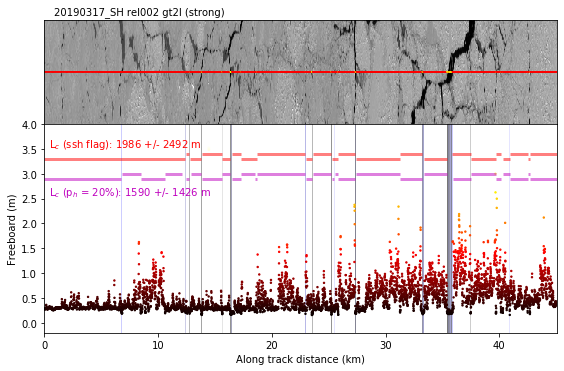

In [54]:
fig= plt.figure(figsize=(10,6))
#fig.patch.set_facecolor('xkcd:white')

#x0 = (sub_dF07['ATrackDist'] - sub_dF07['Length']/2000).values
#x1 = (sub_dF07['ATrackDist'] + sub_dF07['Length']/2000).values
#ssh = sub_dF07['SSHFlag'].values

# ATL07 heights ssh label
#ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=1)
buffer
%matplotlib inline

# Create binary colormap for SSH Flag
cmap_ssh = colors.ListedColormap(['red', 'yellow'])

# Plot 1
fig= plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
plt.imshow(crop, extent=[sub_dF07.ATrackDist.iloc[0], sub_dF07.ATrackDist.iloc[-1], -buffer/1000, +buffer/1000], aspect='auto', cmap='gray', vmin=0, vmax=255)
plt.scatter(sub_dF07['ATrackDist'],np.zeros(len(sub_dF07['ATrackDist'])), c=sub_dF07['SSHFlag'], s=buffer/10000, cmap=cmap_ssh)
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
plt.autoscale(enable=True, axis='x', tight=True)
#plt.suptitle(date, color='k', fontsize=12)
plt.annotate(date+' '+relStr+' '+beam_name+' ('+beamStrength+')', xy=(0.02, 1.05), xycoords='axes fraction')

ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000.
    x1 = row['ATrackDist'] + shadingSize/2000.
    
    if row['SSHFlag'] > 0.5:
        #print(x0, x1)
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)
    elif row['SegType'] > 1.1:
        #print(x0, x1)
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)

plt.scatter(sub_dF07['ATrackDist'], sub_dF07['Height'], c=sub_dF07['Height'], cmap='hot', s=2, zorder=2)

fi=0
for f1 in floe_groups07v1:
    #idx0=np.where(sub_dF07['SegmentID']==floe_groups[f][0])
    #idx1=np.where(sub_dF07['SegmentID']==floe_groups[f][-1])
    x0=f1[0]/1000.
    x1=f1[-1]/1000.
    #print(x0, x1)
    if (fi % 2) == 0: 
        plt.hlines(y=3.3, xmin=x0, xmax=x1, linewidths=3, color='r', alpha=0.5)
    else:
        plt.hlines(y=3.4, xmin=x0, xmax=x1, linewidths=3, color='r', alpha=0.5)
    fi+=1
    
fi=0
for f2 in floe_groups07v2:
    #idx0=np.where(sub_dF10['height_segment_id']==floe_groups10[f][0])
    #idx1=np.where(sub_dF10['height_segment_id']==floe_groups10[f][-1])
    #x0=sub_dF10['ATrackDist'].iloc[idx0].item()
    #x1=sub_dF10['ATrackDist'].iloc[idx1].item()
    #
    x0=f2[0]/1000.
    x1=f2[-1]/1000.
    #print(x0, x1)
    if (fi % 2) == 0: 
        plt.hlines(y=2.9, xmin=x0, xmax=x1, linewidths=3, color='m', alpha=0.5)
    else:
        plt.hlines(y=3., xmin=x0, xmax=x1, linewidths=3, color='m', alpha=0.5)
    fi+=1
ax2.annotate(r'L$_c$ (ssh flag): '+str(floe_lengthv1_mean)+' +/- '+str(floe_lengthv1_std)+' m',xy=(0.01, 0.89), color='r',xycoords='axes fraction')
ax2.annotate(r'L$_c$ (p$_h$ = '+str(percentileThresh)+'%): '+str(floe_lengthv2_mean)+' +/- '+str(floe_lengthv2_std)+' m',xy=(0.01, 0.66), color='m',xycoords='axes fraction')
        
plt.xlim(np.amin(sub_dF07['ATrackDist']), np.amax(sub_dF07['ATrackDist']))
#ax2.xaxis.set_ticklabels([])
plt.ylim(-0.2, 4)
#ax2.annotate('Grey = ssh_flag',xy=(0.02, 0.92), xycoords='axes fraction')
plt.ylabel('Freeboard (m)')
plt.xlabel('Along track distance (km)')
plt.subplots_adjust(left=0.09, right=0.98, top=0.96, bottom=0.09, wspace=0, hspace=0)
plt.savefig(figpath+'FINAL_plot'+date+beam_name+relStr+'p'+str(percentileThresh)+'floeLength.png', dpi=300)

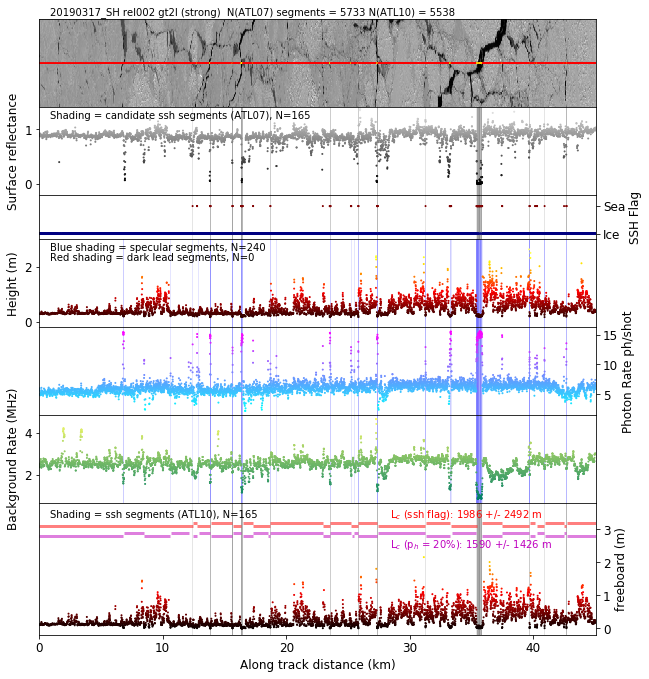

In [55]:
### Generate final plot
shadingSize=30

%matplotlib inline

# Create binary colormap for SSH Flag
cmap_ssh = colors.ListedColormap(['red', 'yellow'])

# Plot 1
fig= plt.figure(figsize=(9,9.5))
fig.patch.set_facecolor('xkcd:white')

ax1 = plt.subplot2grid((14, 1), (0, 0), rowspan=2)
plt.imshow(crop, extent=[sub_dF07.ATrackDist.iloc[0], sub_dF07.ATrackDist.iloc[-1], -buffer/1000, +buffer/1000], aspect='auto', cmap='gray', vmin=0, vmax=255)
plt.scatter(sub_dF07['ATrackDist'],np.zeros(len(sub_dF07['ATrackDist'])), c=sub_dF07['SSHFlag'], s=buffer/10000, cmap=cmap_ssh)
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
plt.autoscale(enable=True, axis='x', tight=True)
#plt.suptitle(date, color='k', fontsize=12)
ax1.annotate(date+' '+relStr+' '+beam_name+' ('+beamStrength+')  N(ATL07) segments = '+str(atl07_segs)+' N(ATL10) = '+str(atl10_segs),xy=(0.02, 1.05), xycoords='axes fraction')

# Plot 2
ax2 = plt.subplot2grid((14, 1), (2, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    if (row['SSHFlag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)

plt.scatter(sub_dF07['ATrackDist'],sub_dF07['BandValue'], c=sub_dF07['BandValue'], s=1, cmap='gray', vmin = 0, vmax = 1.5, zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax2.xaxis.set_ticklabels([])
ax2.set_yticks([0, 1])
plt.ylim(-0.2,1.4)
plt.ylabel('Surface reflectance', color='k', fontsize=12)
ax2.tick_params(axis='y', colors='k', labelsize=12)
ax2.annotate('Shading = candidate ssh segments (ATL07), N='+str(ssh07_segs),xy=(0.02, 0.87), xycoords='axes fraction')
# Plot 3
ax3 = plt.subplot2grid((14, 1), (4, 0), rowspan=1)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    #if ((row['SSHFlag'] > 0.1) & (row['SSHFlag'] < 1.2)):
    if (row['SSHFlag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)

plt.scatter(sub_dF07['ATrackDist'],sub_dF07['SSHFlag'], c=sub_dF07['SSHFlag'], s=1, cmap='jet', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.tick_right()
plt.ylabel('SSH Flag', color='k', fontsize=12)
ax3.yaxis.set_label_position("right")
plt.yticks([0,1], ['Ice', 'Sea'], fontsize=12)
plt.ylim(-0.2,1.4)
ax3.tick_params(axis='y', colors='k')

# Plot 4
ax4 = plt.subplot2grid((14, 1), (5, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    # cloud
    if row['SegType'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.1)
    # Specular lead
    elif ((row['SegType'] > 1.5) & (row['SegType'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    # Dark lead
    elif row['SegType'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.1)
            
plt.scatter(sub_dF07['ATrackDist'],sub_dF07['Height'], c=sub_dF07['Height'], s=1, vmin=0, vmax=3, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax4.xaxis.set_ticklabels([])
plt.ylabel('Height (m)', color='k', fontsize=12)
ax4.tick_params(axis='y', colors='k', labelsize=12)
plt.ylim(-0.2,3)
ax4.annotate('Blue shading = specular segments, N='+str(specular_segs),xy=(0.02, 0.87), xycoords='axes fraction')
ax4.annotate('Red shading = dark lead segments, N='+str(darklead_segs),xy=(0.02, 0.76), xycoords='axes fraction')

# Plot 5
ax5 = plt.subplot2grid((14, 1), (7, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    #x0 = row['ATrackDist'] - row['Length']/2000
    #x1 = row['ATrackDist'] + row['Length']/2000
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    # cloud
    if row['SegType'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.1)
    # specular lead
    elif ((row['SegType'] > 1.5) & (row['SegType'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['SegType'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.1)
            
plt.scatter(sub_dF07['ATrackDist'],sub_dF07['PhRate'], c=sub_dF07['PhRate'], s=1, cmap='cool', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.tick_right()
plt.ylabel('Photon Rate ph/shot', color='k', fontsize=12)
ax5.yaxis.set_label_position("right")
ax5.tick_params(axis='y', colors='k', labelsize=12)

# Plot 6
ax6 = plt.subplot2grid((14, 1), (9, 0), rowspan=2)

for index, row in sub_dF07.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    # cloud
    if row['SegType'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.1)
    # specular lead
    elif ((row['SegType'] > 1.5) & (row['SegType'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['SegType'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.1)
            
plt.scatter(sub_dF07['ATrackDist'],sub_dF07['BackgrRate'], c=sub_dF07['BackgrRate'], s=1, cmap='summer', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax6.xaxis.set_ticklabels([])
plt.ylabel('Background Rate (MHz)', color='k', fontsize=12)
plt.xlabel('Along track distance (km)', color='k', fontsize=16)
ax6.tick_params(axis='y', colors='k', labelsize=12)
ax6.tick_params(axis='x', colors='k', labelsize=12)

### Plot 7 (ICESat-2 background rate)
ax7 = plt.subplot2grid((14, 1), (11, 0), rowspan=3)

# Add lead_flag=1 shading
#for index, row in sub_dF10.iterrows():
    # CHANGE TO LEAD LENGTH
#    x0 = row['ATrackDist'] - shadingSize*2/2000
#    x1 = row['ATrackDist'] + shadingSize*2/2000
#    
#    if row['lead_flag'] > 0.1:
#        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)


for index, row in sub_dF10.iterrows():
    x0 = row['ATrackDist'] - shadingSize/2000
    x1 = row['ATrackDist'] + shadingSize/2000
    
    #if ((row['ssh_flag'] > 1.1) & (row['ssh_flag'] < 2.2)):
    if (row['ssh_flag'] > 0.5):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)
        
plt.scatter(sub_dF10['ATrackDist'],sub_dF10['freeboard'], c=sub_dF10['freeboard'], vmin=0, vmax=3, s=1, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('freeboard (m)', color='k', fontsize=12)
ax7.yaxis.set_label_position("right")
ax7.yaxis.tick_right()
plt.xlabel('Along track distance (km)', color='k', fontsize=12)
ax7.tick_params(axis='y', colors='k', labelsize=12)
ax7.tick_params(axis='x', colors='k', labelsize=12)
ax7.annotate('Shading = ssh segments (ATL10), N='+str(ssh10_segs),xy=(0.02, 0.89), xycoords='axes fraction')
#ax7.annotate('Mean = '+str(mean_fb)+' m / mean > 0.05 = '+str(mean_fb2)+' m',xy=(0.6, 0.84), xycoords='axes fraction')


fi=0
for f1 in floe_groups07v1:
    #idx0=np.where(sub_dF07['SegmentID']==floe_groups[f][0])
    #idx1=np.where(sub_dF07['SegmentID']==floe_groups[f][-1])
    x0=f1[0]/1000.
    x1=f1[-1]/1000.
    #print(x0, x1)
    if (fi % 2) == 0: 
        plt.hlines(y=3.1, xmin=x0, xmax=x1, linewidths=3, color='r', alpha=0.5)
    else:
        plt.hlines(y=3.2, xmin=x0, xmax=x1, linewidths=3, color='r', alpha=0.5)
    fi+=1
    
fi=0
for f2 in floe_groups07v2:
    #idx0=np.where(sub_dF10['height_segment_id']==floe_groups10[f][0])
    #idx1=np.where(sub_dF10['height_segment_id']==floe_groups10[f][-1])
    #x0=sub_dF10['ATrackDist'].iloc[idx0].item()
    #x1=sub_dF10['ATrackDist'].iloc[idx1].item()
    #
    x0=f2[0]/1000.
    x1=f2[-1]/1000.
    #print(x0, x1)
    if (fi % 2) == 0: 
        plt.hlines(y=2.8, xmin=x0, xmax=x1, linewidths=3, color='m', alpha=0.5)
    else:
        plt.hlines(y=2.9, xmin=x0, xmax=x1, linewidths=3, color='m', alpha=0.5)
    fi+=1
ax7.annotate(r'L$_c$ (ssh flag): '+str(floe_lengthv1_mean)+' +/- '+str(floe_lengthv1_std)+' m',xy=(0.63, 0.89), color='r',xycoords='axes fraction')
ax7.annotate(r'L$_c$ (p$_h$ = '+str(percentileThresh)+'%): '+str(floe_lengthv2_mean)+' +/- '+str(floe_lengthv2_std)+' m',xy=(0.63, 0.66), color='m',xycoords='axes fraction')
        
    
plt.ylim(-0.2,3.8)

plt.subplots_adjust(left=0.06, right=0.92, top=0.96, bottom=0.06, wspace=0, hspace=0)
#plt.tight_layout()
### Save plot to file
plt.savefig(figpath+'FINAL_plot'+date+beam_name+relStr+str(Slim)+str(Nlim)+'withFloe.png', dpi=300)


In [56]:
floesT103=np.copy(sub_dF10['ATrackDist'].values*1000.)

for x in range(0, numKms, 10000):
    idxT=np.where((floesT103>x)&(floesT103<(x+10000)))
    print(np.median(sub_dF10['freeboard'].values[idxT])*0.3)
    idxM=np.where((sub_dF10['seg_type_flag'].values[idxT]>1 ) & sub_dF10['freeboard'].values[idxT]<(np.median(sub_dF10['freeboard'].values[idxT])*0.02))
    #print(idxT[0][0]+idxM)
    floesT103[idxT[0][0]+idxM]=-1
floe_groups10v3, lengths10v3 = consecutivev2(floesT103)
lengths10v3


0.04029484838247299


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
### Calculating floe size

#sub_dF07['SegmentID'].values
floesT=np.copy(sub_dF07['SegmentID'].values)
floesT=floesT[np.where(sub_dF07['SSHFlag'].values<0.5)]


def consecutive(data, stepsize=1, minsize=3):
    splitdata=np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    splitdata_cropped=[group for group in splitdata if np.size(group) > minsize]
    return splitdata_cropped

floe_groups=consecutive(floesT)
floe_lengths=[np.size(floe_groupT) for floe_groupT in floe_groups]
#floe_lengths

In [ ]:
### Calculating floe size ATL10

#sub_dF07['SegmentID'].values
floesT10=np.copy(sub_dF10['height_segment_id'].values)
floesT10=floesT10[np.where(sub_dF10['ssh_flag'].values<0.5)]

floe_groups10=consecutive(floesT10)
floe_lengths10=[np.size(floe_groupT) for floe_groupT in floe_groups10]

floesT2=np.copy(sub_dF07['SegmentID'].values)
floesT2=floesT[np.where(sub_dF07['SSHFlag'].values<0.5)]

floe_groups=consecutive(floesT)
floe_lengths=[np.size(floe_groupT) for floe_groupT in floe_groups]
floe_lengths


In [ ]:
floesT072=np.copy(sub_dF07['ATrackDist'].values*1000.)
floesT072[np.where(sub_dF07['SSHFlag'].values>0.5)]=-1
floe_groups07v2, lengths07v2 = consecutivev2(floesT072)
#print(floe_groups07v2)
#print(lengths07v2)

In [ ]:
freeboards=np.copy(sub_dF10['freeboard'].values)

floesT102=np.copy(sub_dF10['ATrackDist'].values*1000.)
floesT102[np.where(freeboards<(np.median(freeboards)*0.3))]=-1
floe_groups10v2, lengths07v2 = consecutivev2(floesT102)
lengths10v2

In [ ]:
### Calculating floe size ATL07 and SSH_FLAG

#def consecutive(data, stepsize=1, minsize=3):
#    # looking for gaps in the height segment ID
#    splitdata=np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
#    splitdata_cropped=[group for group in splitdata if np.size(group) > minsize]
#    return splitdata_cropped

#floesT=np.copy(sub_dF07['SegmentID'].values)
#floesT=floesT[np.where(sub_dF07['SSHFlag'].values<0.5)]

#floe_groups=consecutive(floesT)
#floe_lengths=[np.size(floe_groupT) for floe_groupT in floe_groups]
#floe_lengths